Read And Play with redMaPPer Catalog from cosmoDC2 v1.1.4
---------------------------------------------------------

This notebook shows how to read in the new redMaPPer catalog run on cosmoDC2 v1.1.4.

For reference, the commands to get the data that were used as an input to redmapper were:
```python
import GCRCatalogs
from astropy.table import Table

gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')
quantities_wanted = ['galaxy_id', 'ra', 'dec', 'redshift', 
                     'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst',
                     'mag_true_z_lsst', 'mag_true_y_lsst', 'halo_id',
                     'halo_mass', 'is_central']
query = GCRCatalogs.GCRQuery('mag_true_z_lsst < 25.5')
data = Table(gc.get_quantities(quantities_wanted, [query]))
data.write('cosmoDC2_v1.1.4_raw.fits', format='fits')
```

The actual running of redmapper will be described in a later document, but requires many more resources than are available in a notebook.  The red-sequence model was trained starting with a sample of ~3000 spectra (true redshift) of halo centrals with  halo_mass > 3e13, covering ~30% of the cosmoDC2 footprint.

In [1]:
import GCRCatalogs
from astropy.table import Table
import esutil
import numpy as np
import matplotlib.pyplot as plt

First we read in the cluster catalog.  The catalog that is distributed has been cut to lambda>20, which means that there are the equivalent of 20 red galaxies brighter than 0.2L* within the optimal cluster radius.  This corresponds to a mass threshold of appriximately 1e14 M_sun.

In [2]:
# Get the redMaPPer catalog
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.2.1py')

In [3]:
# Select out the cluster and member quantities into different lists
quantities = gc.list_all_quantities()
# These are the quantities that describe the clusters and the central galaxies
cluster_quantities = [q for q in quantities if 'member' not in q]
# These are the quantities that describe the members
member_quantities = [q for q in quantities if 'member' in q]

In [4]:
# The clusters and members are linked via "cluster_id"
print(cluster_quantities)

['id_cen_4', 'id_cen_0', 'dec_cen_3', 'id_cen_3', 'richness', 'ra_cen_0', 'ra', 'scaleval', 'dec_cen_2', 'cluster_id', 'id_cen_1', 'redshift', 'dec_cen_0', 'p_cen_3', 'p_cen_1', 'ra_cen_3', 'dec_cen_1', 'p_cen_0', 'ra_cen_4', 'ra_cen_2', 'richness_err', 'ra_cen_1', 'redshift_true_cg', 'dec', 'p_cen_4', 'redshift_err', 'maskfrac', 'dec_cen_4', 'p_cen_2', 'id_cen_2']


In [5]:
print(member_quantities)

['theta_i_member', 'mag_i_lsst_member', 'refmag_member', 'cluster_id_member', 'magerr_z_lsst_member', 'magerr_y_lsst_member', 'dec_member', 'theta_r_member', 'magerr_g_lsst_member', 'magerr_i_lsst_member', 'mag_r_lsst_member', 'ra_member', 'pfree_member', 'p_member', 'redshift_true_member', 'refmag_err_member', 'mag_y_lsst_member', 'magerr_r_lsst_member', 'mag_z_lsst_member', 'mag_g_lsst_member', 'id_member']


In [6]:
# Read in the cluster and member data
cluster_data = Table(gc.get_quantities(cluster_quantities))
member_data = Table(gc.get_quantities(member_quantities))

Text(0,0.5,'z_spec_central')

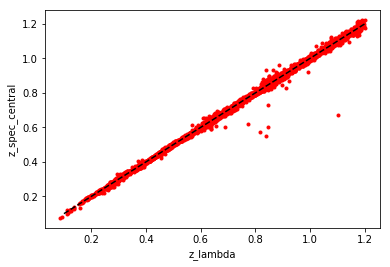

In [7]:
# Compare the cluster photo-z to the central galaxy redshift
plt.plot(cluster_data['redshift'], cluster_data['redshift_true_cg'], 'r.')
plt.plot([0.1, 1.2], [0.1, 1.2], 'k--')
plt.xlabel('z_lambda')
plt.ylabel('z_spec_central')

This is a plot comparing the cluster photo-z (`z_lambda`) which is computed by fitting all the members to the red-sequence model simultaneously, to the true (spectroscopic) redshift of the central galaxy (z_spec_central).
The photo-z performance is very good, made possible by the fact that (a) cluster redshift finding can be very precise by fitting 20 red galaxies simultaneously, and (b) the extragalactic catalog is blissfully free of systematics.
However, there are some outliers.  As shown below these outliers are where redMaPPer has chosen an incorrect central galaxy, so the *central* redshift doesn't agree with the cluster redshift, but the average of the member redshifts is consistent with the cluster redshift.

## Now let's match the cluster centrals and members by the galaxy ID to look at the central colors

In [8]:
# First, we will want to read in the "truth" as a comparison
# Note that we're just reading in the small subset for a faster comparison
gc_truth = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
quantities_wanted = ['mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_y_lsst', 'redshift']
query = GCRCatalogs.GCRQuery('(is_central == True) & (halo_mass > 5e13)')
truth_data = Table(gc_truth.get_quantities(quantities_wanted, [query]))

In [9]:
a, b = esutil.numpy_util.match(cluster_data['id_cen_0'], member_data['id_member'])
a.size

4515

Text(0,0.5,'g-r of central galaxy')

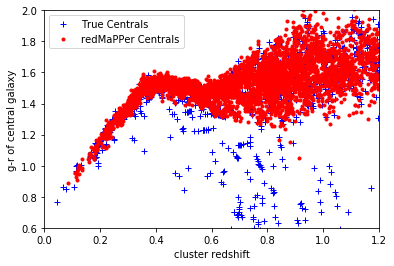

In [10]:
plt.plot(truth_data['redshift'], truth_data['mag_true_g_lsst'] - truth_data['mag_true_r_lsst'], 'b+', label='True Centrals')
plt.plot(cluster_data['redshift'][a], member_data['mag_g_lsst_member'][b] - member_data['mag_r_lsst_member'][b], 'r.', label='redMaPPer Centrals')
plt.xlim(0.0, 1.2)
plt.ylim(0.6,2.0)
plt.legend()
plt.xlabel('cluster redshift')
plt.ylabel('g-r of central galaxy')

The above plot is a comparison of the the g-r color as a function of redshift of "true" centrals (from the extragalactic catalog), in blue, to the color as a function of redshift of redMaPPer centrals (in red).  redMaPPer only finds the red centrals, and thus any halo/cluster with a blue central will be miscentered by redMaPPer (the true rate of clusters with blue centrals at z<1.0 is of some debate).  Other than that, the color distribution of centrals found by redMaPPer is consistent with that of the true centrals.
The g-r color is most reliable at z<0.4 due to the location of the 4000A break.

Text(0,0.5,'r-i of central galaxy')

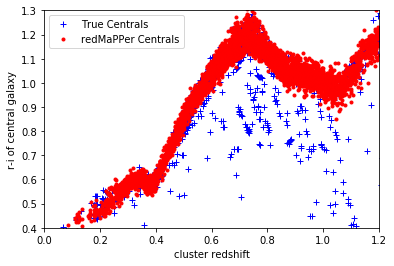

In [11]:
plt.plot(truth_data['redshift'], truth_data['mag_true_r_lsst'] - truth_data['mag_true_i_lsst'], 'b+', label='True Centrals')
plt.plot(cluster_data['redshift'][a], member_data['mag_r_lsst_member'][b] - member_data['mag_i_lsst_member'][b], 'r.', label='redMaPPer Centrals')
plt.xlim(0.0, 1.2)
plt.ylim(0.4, 1.3)
plt.legend()
plt.xlabel('cluster redshift')
plt.ylabel('r-i of central galaxy')

Same as the plot above, except for the r-i color.  This is more reliable at z<0.8.  The hitch between 0.35<z<0.40 is a feature of the extragalactic catalog that is not seen in real data.

Text(0,0.5,'i-z of central galaxy')

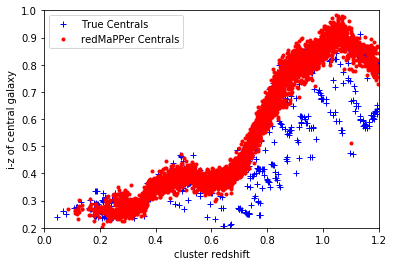

In [12]:
plt.plot(truth_data['redshift'], truth_data['mag_true_i_lsst'] - truth_data['mag_true_z_lsst'], 'b+', label='True Centrals')
plt.plot(cluster_data['redshift'][a], member_data['mag_i_lsst_member'][b] - member_data['mag_z_lsst_member'][b], 'r.', label='redMaPPer Centrals')
plt.xlim(0.0, 1.2)
plt.ylim(0.2, 1.0)
plt.legend()
plt.xlabel('cluster redshift')
plt.ylabel('i-z of central galaxy')

Same as the plots above, except for the i-z color.  This is most useful at 0.7<z<1.0.  

Text(0,0.5,'z-y of central galaxy')

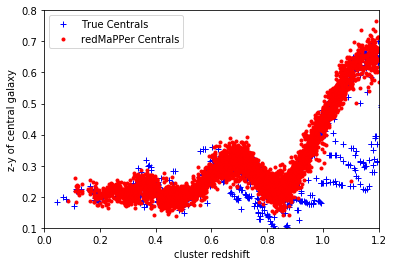

In [13]:
plt.plot(truth_data['redshift'], truth_data['mag_true_z_lsst'] - truth_data['mag_true_y_lsst'], 'b+', label='True Centrals')
plt.plot(cluster_data['redshift'][a], member_data['mag_z_lsst_member'][b] - member_data['mag_y_lsst_member'][b], 'r.', label='redMaPPer Centrals')
plt.xlim(0.0, 1.2)
plt.ylim(0.1, 0.8)
plt.legend()
plt.xlabel('cluster redshift')
plt.ylabel('z-y of central galaxy')

Same as the plots above, except for the z-y color.  If the y-band galaxy measurements are reliable in real LSST data, this will allow robust red-sequence cluster finding to z<~1.2.

## Match Clusters and Members to look at the median member redshift
In this section we are going to compare clusters to members and look at the median member redshift.  This is only possible with mock catalogs where we have true redshifts for all members.

In [14]:
# Clean out any members without ztrue information
# There are a few of these due to a very small id-matching bug that was fixed in post-processing for ~99.9% of the members.
ok, = np.where(member_data['redshift_true_member'] > 0.0)
mem = member_data[ok]

In [15]:
# match clusters to members using cluster_id
a, b = esutil.numpy_util.match(cluster_data['cluster_id'], mem['cluster_id_member'])
# Use the reverse indicies from esutil histogram to group these into cluster bins
h, rev = esutil.stat.histogram(a, rev=True)
mem_zmedian = np.zeros(len(cluster_data))
for i in range(len(cluster_data)):
    i1a = rev[rev[i]: rev[i + 1]]
    mem_zmedian[i] = np.median(mem['redshift_true_member'][i1a])


Text(0,0.5,'Median true redshift from members')

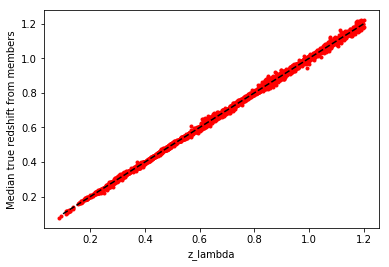

In [16]:
plt.plot(cluster_data['redshift'], mem_zmedian, 'r.')
plt.plot([0.1, 1.2], [0.1, 1.2], 'k--')
plt.xlabel('z_lambda')
plt.ylabel('Median true redshift from members')

This is a plot of the median true redshift of the members vs the cluster photo-z (z_lambda).  The outliers seen above are gone, showing that these outliers where the *central* galaxy did not agree with the cluster photo-z were due to miscentering and not due to problems with the photo-zs.

## Look at cluster richness and redshift

Text(0,0.5,'log10(Cluster Richness)')

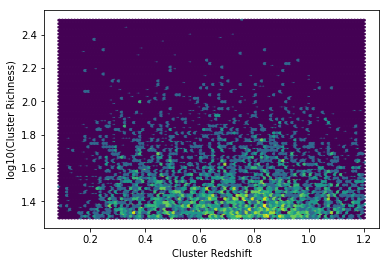

In [17]:
plt.hexbin(cluster_data['redshift'], np.log10(cluster_data['richness']), bins='log')
plt.xlabel('Cluster Redshift')
plt.ylabel('log10(Cluster Richness)')

This is a simple visualization of where the clusters are in terms of richness and redshift.  There are many fewer lambda>20 clusters at z>1.0 because of both evolution of the halo mass function and evolution of the red-sequence such that there are fewer red galaxies per cluster at high redshift.